In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr2-RNR"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Phemernr2-RNR_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(6425, 768)

In [3]:
data = pd.read_csv("../../data/phemernr2_dataset_with_tvt.csv", sep=",")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1
0,552833795142209536,the east london mosque would like to offer its...,non-rumours,training,training
1,580318210609696769,breaking - a germanwings airbus a320 plane rep...,true,validation,testting
2,552798891994009601,reports that two of the dead in the #charliehe...,true,training,training
3,576790814942236672,after #putin disappeared russian tv no longer ...,non-rumours,validation,training
4,499678822598340608,saw #ferguson for myself. #justiceformichaelbr...,non-rumours,testting,testting


In [4]:
data['label'] = data['label'].replace(['true', 'unverfied', 'false'], 'rumours')

In [5]:
labels_str = ['rumours', 'non-rumours']
labels_str

['rumours', 'non-rumours']

In [6]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] == "rumours":
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [7]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [8]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4336, 768)
(1462, 768)
(627, 768)
(4336,)
(1462,)
(627,)


In [9]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(5798, 768)


In [10]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(5798,)


In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [12]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 2-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 90.08620689655173
Saving after new best accuracy : 90.77586206896552
Saving after new best accuracy : 93.79310344827586
Saving after new best accuracy : 94.13793103448276
-- Epoch 50, Train_Accuracy : 92.08710651142734, Validation Accuracy : 91.37931034482759, Train Loss : 2.0018456131219864, Validation Loss : 0.5688895434141159
-- Epoch 100, Train_Accuracy : 93.10047434238896, Validation Accuracy : 92.75862068965517, Train Loss : 1.7205779775977135, Validation Loss : 0.5125270187854767
-- Epoch 150, Train_Accuracy : 93.16515739542906, Validation Accuracy : 92.06896551724138, Train Loss : 1.6098734810948372, Validation Loss : 0.5729587525129318
Saving after new best accuracy : 94.3103448275862
Saving after new best accuracy : 94.39655172413794
Saving after new best accuracy : 94.56896551724138
Saving after new best accuracy : 94.74137931034483
Saving after

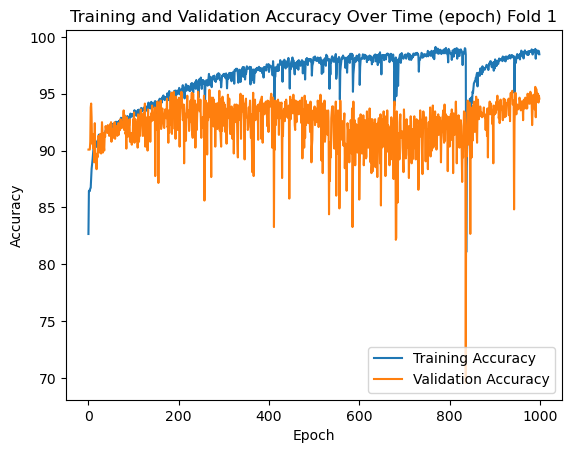

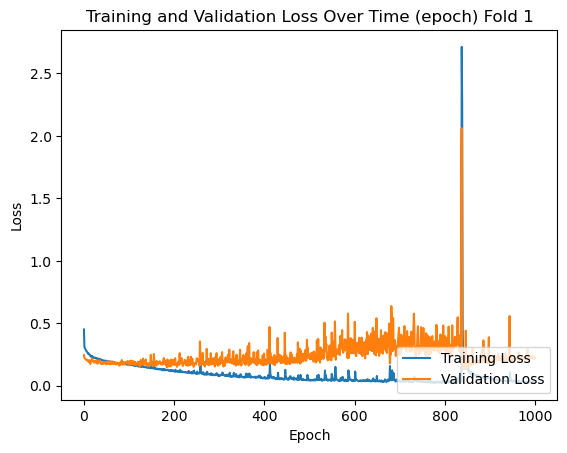

Exec Time : 73.15 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3381
False Positive : 6
False Negative : 26
True Negative : 1225

Class non-rumours Evaluation
- Precision : 99.823 %
- Recall : 99.237 %
- F1 : 0.99529

Class rumours Evaluation
- Precision : 97.922 %
- Recall : 99.513 %
- F1 : 0.98711

Combined Evaluation
- Accuracy : 99.31 %
- Precision : 98.872 %
- Recall : 99.375 %
- F1 : 0.99123
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Train, 99.31, 98.872, 99.375, 0.99123, 99.823, 99.237, 0.99529, 97.922, 99.513, 0.98711, 
Confusion Matrix Scikit-learn: 
[[1225    6]
 [  26 3381]]


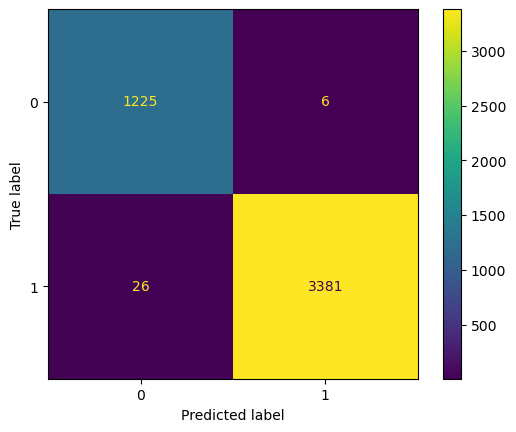


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 817
False Positive : 16
False Negative : 35
True Negative : 292

Class non-rumours Evaluation
- Precision : 98.079 %
- Recall : 95.892 %
- F1 : 0.96973

Class rumours Evaluation
- Precision : 89.297 %
- Recall : 94.805 %
- F1 : 0.91969

Combined Evaluation
- Accuracy : 95.603 %
- Precision : 93.688 %
- Recall : 95.349 %
- F1 : 0.94511
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Validation, 95.603, 93.688, 95.349, 0.94511, 98.079, 95.892, 0.96973, 89.297, 94.805, 0.91969, 
Confusion Matrix Scikit-learn: 
[[292  16]
 [ 35 817]]


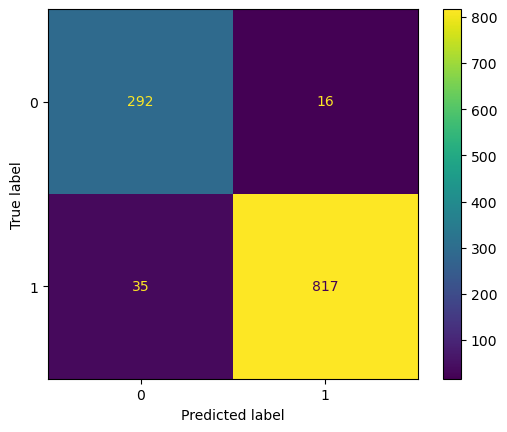


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 428
False Positive : 35
False Negative : 33
True Negative : 131

Class non-rumours Evaluation
- Precision : 92.441 %
- Recall : 92.842 %
- F1 : 0.92641

Class rumours Evaluation
- Precision : 79.878 %
- Recall : 78.916 %
- F1 : 0.79394

Combined Evaluation
- Accuracy : 89.155 %
- Precision : 86.159 %
- Recall : 85.879 %
- F1 : 0.86019
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Test, 89.155, 86.159, 85.879, 0.86019, 92.441, 92.842, 0.92641, 79.878, 78.916, 0.79394, 
627
627
Confusion Matrix Scikit-learn: 
[[131  35]
 [ 33 428]]


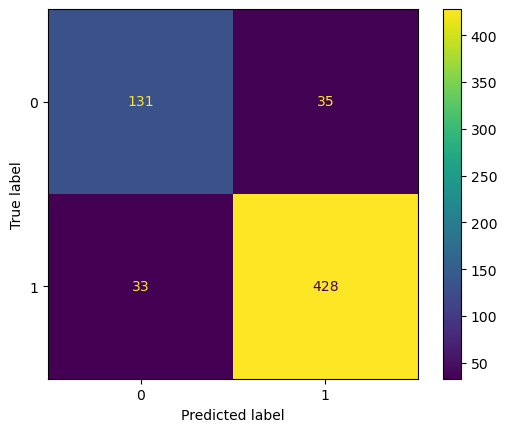

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 89.48275862068965
Saving after new best accuracy : 89.74137931034483
Saving after new best accuracy : 90.60344827586206
Saving after new best accuracy : 91.89655172413794
Saving after new best accuracy : 92.06896551724138
Saving after new best accuracy : 92.5
-- Epoch 50, Train_Accuracy : 92.28115567054765, Validation Accuracy : 91.63793103448276, Train Loss : 1.9527233093976974, Validation Loss : 0.5607158690690994
Saving after new best accuracy : 92.58620689655173
Saving after new best accuracy : 92.93103448275862
Saving after new best accuracy : 93.01724137931035
-- Epoch 100, Train_Accuracy : 93.2514014661492, Validation Accuracy : 92.15517241379311, Train Loss : 1.675168700516224, Validation Loss : 0.5413429886102676
Saving after new best accuracy : 93.1896551724138
Saving after new best accuracy : 93.36206896551724
-- Epoch 150, Train_Accuracy : 94.30789133247089, Validation Accuracy : 93.1896551724138, Train Loss : 1.45

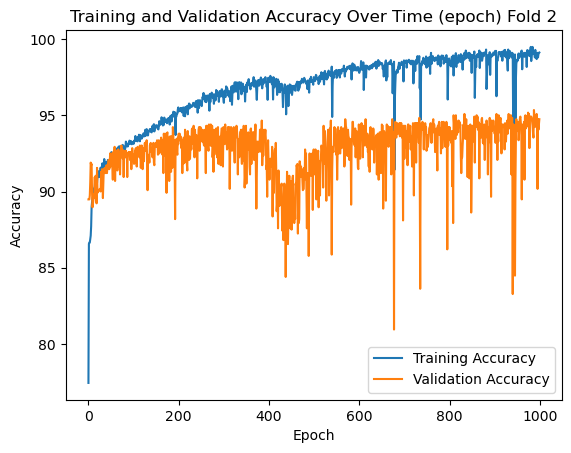

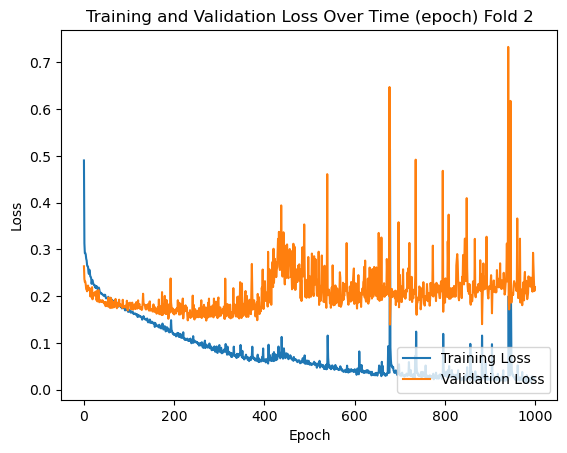

Exec Time : 75.47 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3401
False Positive : 3
False Negative : 6
True Negative : 1228

Class non-rumours Evaluation
- Precision : 99.912 %
- Recall : 99.824 %
- F1 : 0.99868

Class rumours Evaluation
- Precision : 99.514 %
- Recall : 99.756 %
- F1 : 0.99635

Combined Evaluation
- Accuracy : 99.806 %
- Precision : 99.713 %
- Recall : 99.79 %
- F1 : 0.99751
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Train, 99.806, 99.713, 99.79, 0.99751, 99.912, 99.824, 0.99868, 99.514, 99.756, 0.99635, 
Confusion Matrix Scikit-learn: 
[[1228    3]
 [   6 3401]]


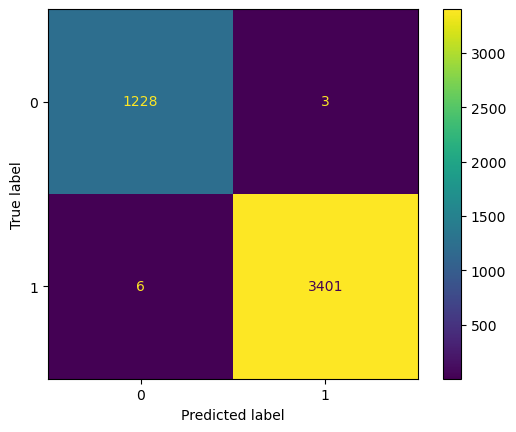


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 810
False Positive : 12
False Negative : 42
True Negative : 296

Class non-rumours Evaluation
- Precision : 98.54 %
- Recall : 95.07 %
- F1 : 0.96774

Class rumours Evaluation
- Precision : 87.574 %
- Recall : 96.104 %
- F1 : 0.91641

Combined Evaluation
- Accuracy : 95.345 %
- Precision : 93.057 %
- Recall : 95.587 %
- F1 : 0.94305
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Validation, 95.345, 93.057, 95.587, 0.94305, 98.54, 95.07, 0.96774, 87.574, 96.104, 0.91641, 
Confusion Matrix Scikit-learn: 
[[296  12]
 [ 42 810]]


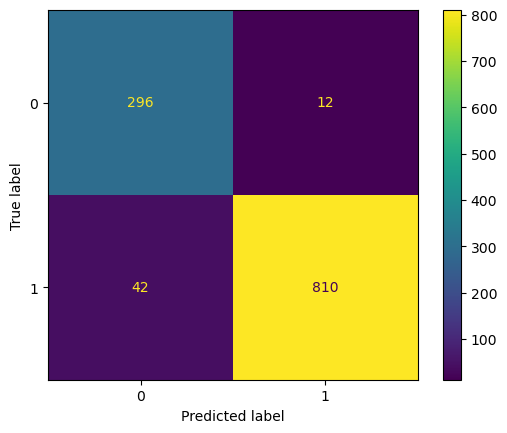


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 419
False Positive : 32
False Negative : 42
True Negative : 134

Class non-rumours Evaluation
- Precision : 92.905 %
- Recall : 90.889 %
- F1 : 0.91886

Class rumours Evaluation
- Precision : 76.136 %
- Recall : 80.723 %
- F1 : 0.78363

Combined Evaluation
- Accuracy : 88.198 %
- Precision : 84.521 %
- Recall : 85.806 %
- F1 : 0.85159
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Test, 88.198, 84.521, 85.806, 0.85159, 92.905, 90.889, 0.91886, 76.136, 80.723, 0.78363, 
627
627
Confusion Matrix Scikit-learn: 
[[134  32]
 [ 42 419]]


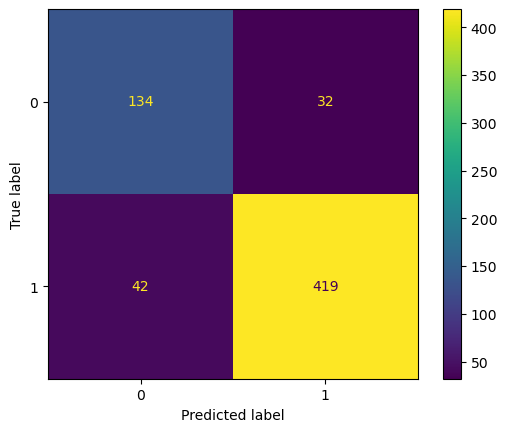

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 88.36206896551724
Saving after new best accuracy : 88.62068965517241
Saving after new best accuracy : 89.39655172413794
Saving after new best accuracy : 91.37931034482759
Saving after new best accuracy : 92.06896551724138
Saving after new best accuracy : 92.75862068965517
-- Epoch 50, Train_Accuracy : 92.0008624407072, Validation Accuracy : 91.98275862068965, Train Loss : 1.9379071444272995, Validation Loss : 0.5588979423046112
Saving after new best accuracy : 92.93103448275862
Saving after new best accuracy : 93.1896551724138
Saving after new best accuracy : 93.53448275862068
-- Epoch 100, Train_Accuracy : 93.14359637774903, Validation Accuracy : 92.84482758620689, Train Loss : 1.7132901772856712, Validation Loss : 0.5213304311037064
Saving after new best accuracy : 93.70689655172414
Saving after new best accuracy : 94.05172413793103
-- Epoch 150, Train_Accuracy : 94.5019404915912, Validation Accuracy : 93.87931034482759, Tra

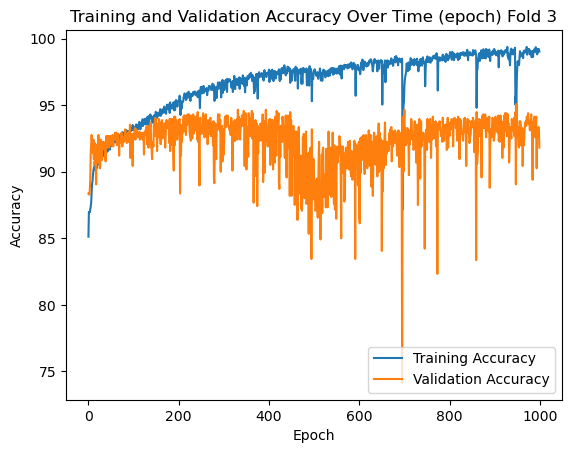

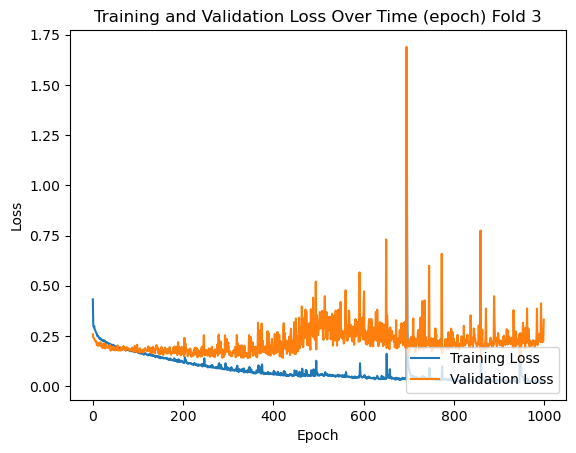

Exec Time : 55.28 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3286
False Positive : 35
False Negative : 121
True Negative : 1196

Class non-rumours Evaluation
- Precision : 98.946 %
- Recall : 96.448 %
- F1 : 0.97681

Class rumours Evaluation
- Precision : 90.812 %
- Recall : 97.157 %
- F1 : 0.93878

Combined Evaluation
- Accuracy : 96.636 %
- Precision : 94.879 %
- Recall : 96.803 %
- F1 : 0.95831
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Train, 96.636, 94.879, 96.803, 0.95831, 98.946, 96.448, 0.97681, 90.812, 97.157, 0.93878, 
Confusion Matrix Scikit-learn: 
[[1196   35]
 [ 121 3286]]


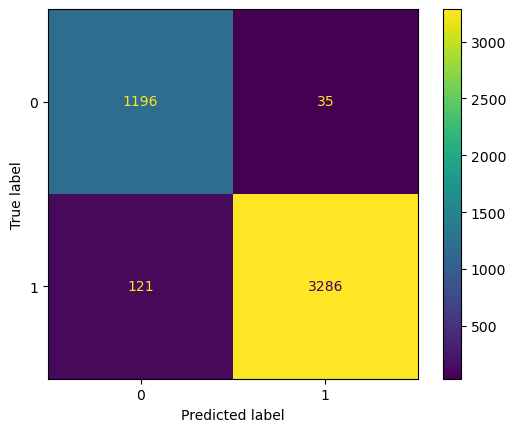


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 800
False Positive : 5
False Negative : 52
True Negative : 303

Class non-rumours Evaluation
- Precision : 99.379 %
- Recall : 93.897 %
- F1 : 0.9656

Class rumours Evaluation
- Precision : 85.352 %
- Recall : 98.377 %
- F1 : 0.91403

Combined Evaluation
- Accuracy : 95.086 %
- Precision : 92.365 %
- Recall : 96.137 %
- F1 : 0.94213
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Validation, 95.086, 92.365, 96.137, 0.94213, 99.379, 93.897, 0.9656, 85.352, 98.377, 0.91403, 
Confusion Matrix Scikit-learn: 
[[303   5]
 [ 52 800]]


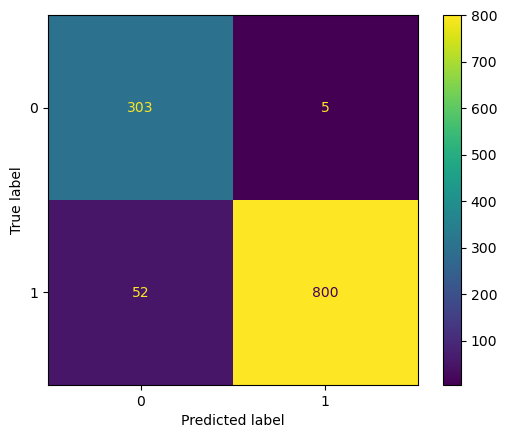


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 420
False Positive : 32
False Negative : 41
True Negative : 134

Class non-rumours Evaluation
- Precision : 92.92 %
- Recall : 91.106 %
- F1 : 0.92004

Class rumours Evaluation
- Precision : 76.571 %
- Recall : 80.723 %
- F1 : 0.78592

Combined Evaluation
- Accuracy : 88.357 %
- Precision : 84.746 %
- Recall : 85.915 %
- F1 : 0.85326
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Test, 88.357, 84.746, 85.915, 0.85326, 92.92, 91.106, 0.92004, 76.571, 80.723, 0.78592, 
627
627
Confusion Matrix Scikit-learn: 
[[134  32]
 [ 41 420]]


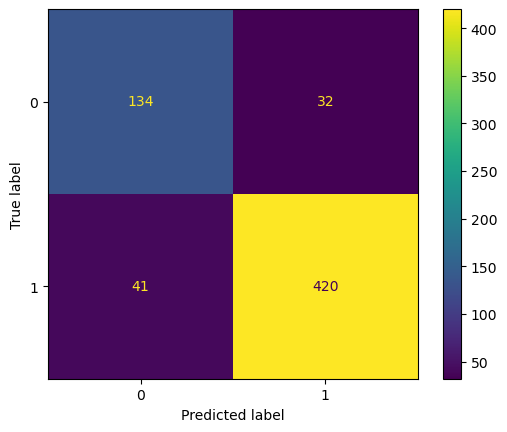

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 86.97152717860224
Saving after new best accuracy : 87.23037100949094
Saving after new best accuracy : 88.78343399482313
Saving after new best accuracy : 91.2855910267472
Saving after new best accuracy : 91.37187230371009
-- Epoch 50, Train_Accuracy : 92.3474886829058, Validation Accuracy : 90.25021570319241, Train Loss : 1.8826722726225853, Validation Loss : 0.7515383511781693
Saving after new best accuracy : 91.458153580673
Saving after new best accuracy : 91.54443485763589
Saving after new best accuracy : 91.63071613459879
Saving after new best accuracy : 91.88955996548749
-- Epoch 100, Train_Accuracy : 93.64087087734426, Validation Accuracy : 91.88955996548749, Train Loss : 1.6285609155893326, Validation Loss : 0.7226476818323135
Saving after new best accuracy : 92.0621225194133
Saving after new best accuracy : 92.14840379637619
Saving after new best accuracy : 92.49352890422779
Saving after new best accuracy : 92.579810181

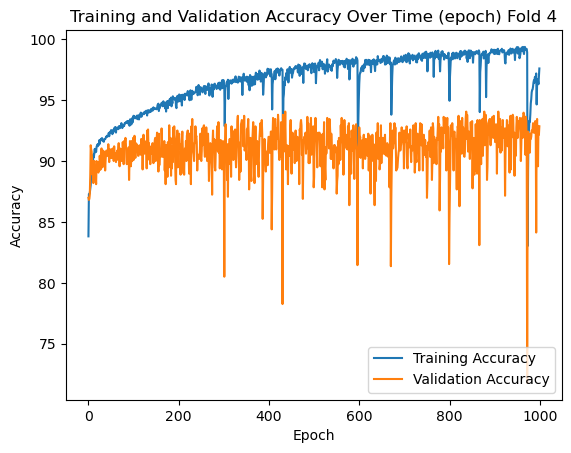

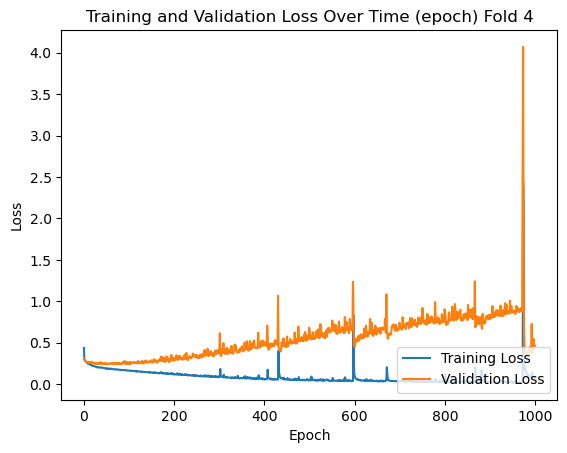

Exec Time : 52.75 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([4639])
Binary Class Evaluation

True Positive : 3307
False Positive : 15
False Negative : 100
True Negative : 1217

Class non-rumours Evaluation
- Precision : 99.548 %
- Recall : 97.065 %
- F1 : 0.98291

Class rumours Evaluation
- Precision : 92.407 %
- Recall : 98.782 %
- F1 : 0.95488

Combined Evaluation
- Accuracy : 97.521 %
- Precision : 95.978 %
- Recall : 97.924 %
- F1 : 0.96941
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Train, 97.521, 95.978, 97.924, 0.96941, 99.548, 97.065, 0.98291, 92.407, 98.782, 0.95488, 
Confusion Matrix Scikit-learn: 
[[1217   15]
 [ 100 3307]]


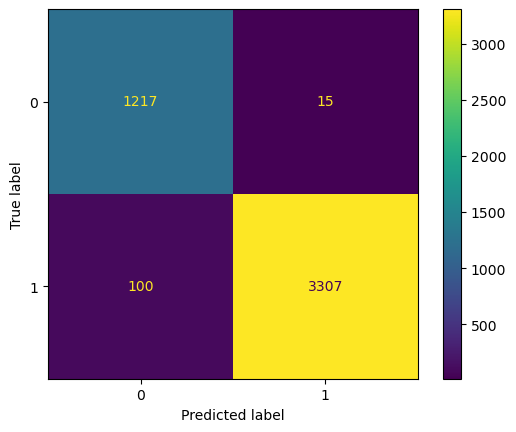


Validation Set
Predictions : torch.Size([1159])
Binary Class Evaluation

True Positive : 813
False Positive : 30
False Negative : 39
True Negative : 277

Class non-rumours Evaluation
- Precision : 96.441 %
- Recall : 95.423 %
- F1 : 0.95929

Class rumours Evaluation
- Precision : 87.658 %
- Recall : 90.228 %
- F1 : 0.88925

Combined Evaluation
- Accuracy : 94.047 %
- Precision : 92.05 %
- Recall : 92.825 %
- F1 : 0.92436
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Validation, 94.047, 92.05, 92.825, 0.92436, 96.441, 95.423, 0.95929, 87.658, 90.228, 0.88925, 
Confusion Matrix Scikit-learn: 
[[277  30]
 [ 39 813]]


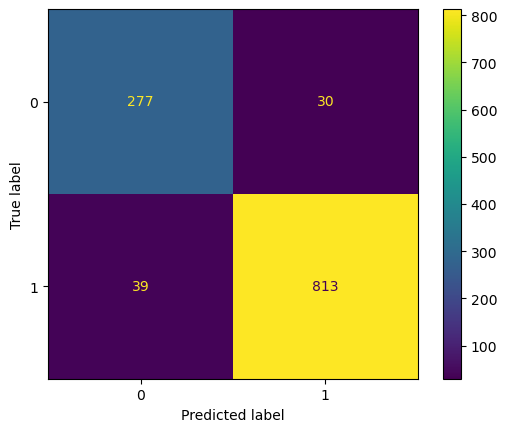


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 414
False Positive : 28
False Negative : 47
True Negative : 138

Class non-rumours Evaluation
- Precision : 93.665 %
- Recall : 89.805 %
- F1 : 0.91694

Class rumours Evaluation
- Precision : 74.595 %
- Recall : 83.133 %
- F1 : 0.78632

Combined Evaluation
- Accuracy : 88.038 %
- Precision : 84.13 %
- Recall : 86.469 %
- F1 : 0.85283
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Test, 88.038, 84.13, 86.469, 0.85283, 93.665, 89.805, 0.91694, 74.595, 83.133, 0.78632, 
627
627
Confusion Matrix Scikit-learn: 
[[138  28]
 [ 47 414]]


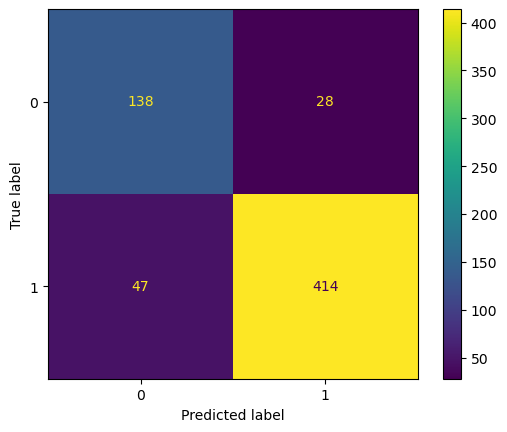

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 80.8455565142364
Saving after new best accuracy : 80.93183779119931
Saving after new best accuracy : 81.10440034512511
Saving after new best accuracy : 81.2769628990509
Saving after new best accuracy : 82.3986194995686
Saving after new best accuracy : 83.60655737704919
Saving after new best accuracy : 85.33218291630716
Saving after new best accuracy : 85.84987057808456
Saving after new best accuracy : 86.10871440897326
Saving after new best accuracy : 86.54012079378775
Saving after new best accuracy : 86.79896462467644
-- Epoch 50, Train_Accuracy : 94.28756197456349, Validation Accuracy : 86.54012079378775, Train Loss : 1.4146674536168575, Validation Loss : 1.1295296847820282
Saving after new best accuracy : 86.97152717860224
Saving after new best accuracy : 87.23037100949094
-- Epoch 100, Train_Accuracy : 95.34382410002155, Validation Accuracy : 86.19499568593615, Train Loss : 1.1626173630356789, Validation Loss : 1.258574783

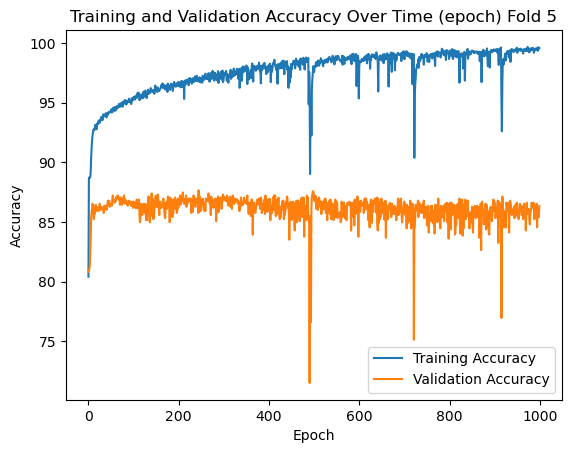

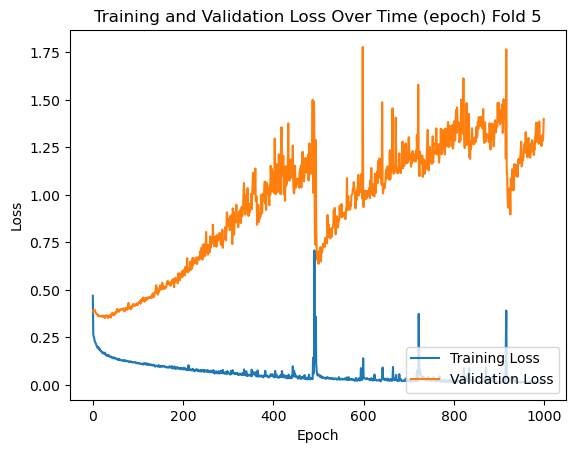

Exec Time : 54.13 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([4639])
Binary Class Evaluation

True Positive : 3282
False Positive : 12
False Negative : 126
True Negative : 1219

Class non-rumours Evaluation
- Precision : 99.636 %
- Recall : 96.303 %
- F1 : 0.97941

Class rumours Evaluation
- Precision : 90.632 %
- Recall : 99.025 %
- F1 : 0.94643

Combined Evaluation
- Accuracy : 97.025 %
- Precision : 95.134 %
- Recall : 97.664 %
- F1 : 0.96382
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Train, 97.025, 95.134, 97.664, 0.96382, 99.636, 96.303, 0.97941, 90.632, 99.025, 0.94643, 
Confusion Matrix Scikit-learn: 
[[1219   12]
 [ 126 3282]]


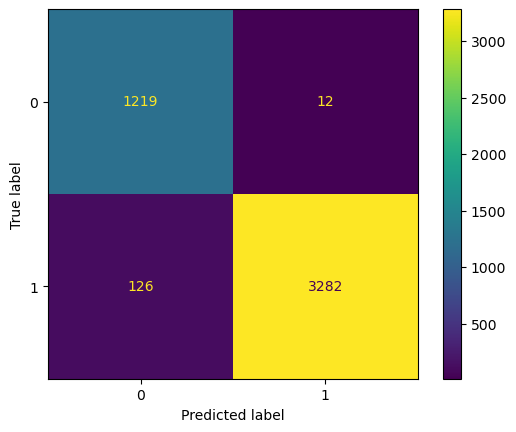


Validation Set
Predictions : torch.Size([1159])
Binary Class Evaluation

True Positive : 762
False Positive : 54
False Negative : 89
True Negative : 254

Class non-rumours Evaluation
- Precision : 93.382 %
- Recall : 89.542 %
- F1 : 0.91422

Class rumours Evaluation
- Precision : 74.052 %
- Recall : 82.468 %
- F1 : 0.78034

Combined Evaluation
- Accuracy : 87.662 %
- Precision : 83.717 %
- Recall : 86.005 %
- F1 : 0.84846
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Validation, 87.662, 83.717, 86.005, 0.84846, 93.382, 89.542, 0.91422, 74.052, 82.468, 0.78034, 
Confusion Matrix Scikit-learn: 
[[254  54]
 [ 89 762]]


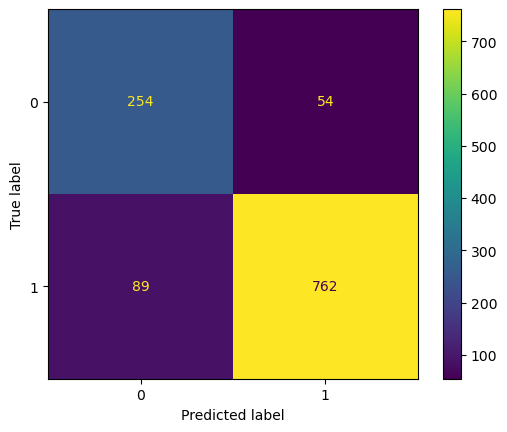


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 419
False Positive : 32
False Negative : 42
True Negative : 134

Class non-rumours Evaluation
- Precision : 92.905 %
- Recall : 90.889 %
- F1 : 0.91886

Class rumours Evaluation
- Precision : 76.136 %
- Recall : 80.723 %
- F1 : 0.78363

Combined Evaluation
- Accuracy : 88.198 %
- Precision : 84.521 %
- Recall : 85.806 %
- F1 : 0.85159
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Test, 88.198, 84.521, 85.806, 0.85159, 92.905, 90.889, 0.91886, 76.136, 80.723, 0.78363, 
627
627
Confusion Matrix Scikit-learn: 
[[134  32]
 [ 42 419]]


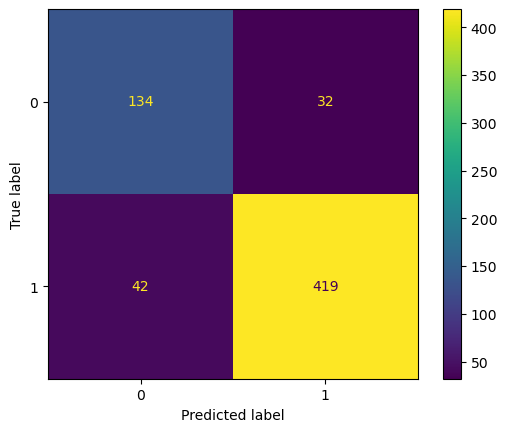

In [13]:
print("Multiclass Classification using 2-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_2LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()